In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

Data Generation

Input shape: (1000, 2)
Output shape: (1000, 2)


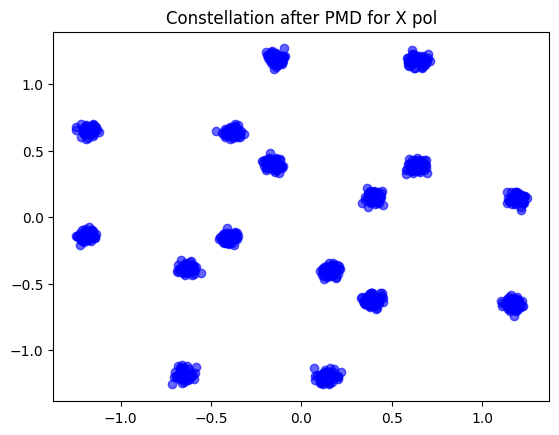

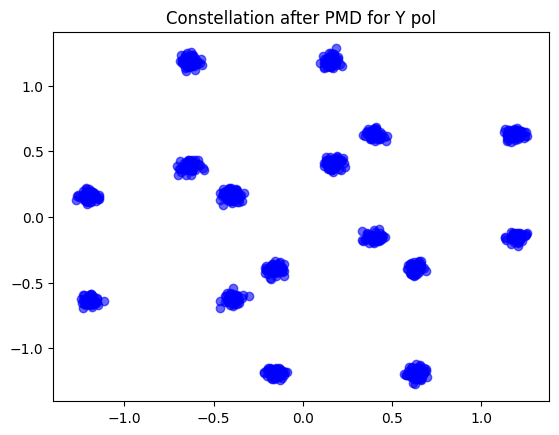

In [2]:
def apply_pmd(E_in, DGD_ps_per_sqrt_km, L_m, N_sections, Rs, SpS):
    N_samples = E_in.shape[0]
    SD_tau = np.sqrt(3 * np.pi / 8) * DGD_ps_per_sqrt_km

    tau = (SD_tau * np.sqrt(L_m * 1e-3) / np.sqrt(N_sections)) * 1e-12
    w = 2 * np.pi * np.fft.fftshift(np.linspace(-0.5, 0.5, N_samples)) * SpS * Rs

    E_V = np.fft.fft(E_in[:, 0])
    E_H = np.fft.fft(E_in[:, 1])

    for _ in range(N_sections):
        # Random complex coupling matrices (unitary)
        X = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
        U, _, Vh = np.linalg.svd(X)
        V = Vh.conj().T
        # Rotate fields by U†
        E1 = U[0, 0].conj() * E_V + U[0, 1].conj() * E_H
        E2 = U[1, 0].conj() * E_V + U[1, 1].conj() * E_H

        # Apply differential delay
        E1 *= np.exp(1j * w * tau / 2)
        E2 *= np.exp(-1j * w * tau / 2)

        # Rotate by V
        E_V = V[0, 0] * E1 + V[0, 1] * E2
        E_H = V[1, 0] * E1 + V[1, 1] * E2
       

    E_out_x = np.fft.ifft(E_V)
    E_out_y = np.fft.ifft(E_H)

    return np.column_stack((E_out_x, E_out_y))


N_symbols = 1000
levels = np.array([-1, 1]) / np.sqrt(2)
qam_symbols_x = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))
qam_symbols_y = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))

E_in = np.column_stack((qam_symbols_x, qam_symbols_y))  # shape (100, 2)


"""Here I have set DGD low for now because CMA itself is giving bad outputs for high DGD aim is for 
RL to first fix polarisation mixing"""
E_out = apply_pmd( 
E_in=E_in, 
DGD_ps_per_sqrt_km=1, # typical mean DGD for 3 symbols DGD
L_m=10000, # fiber length
N_sections=20, # number of fiber sections 
Rs=32e9, # 32 gbaud    
SpS=2 # samples per symbol 
)

print("Input shape:", E_in.shape)
print("Output shape:", E_out.shape)

plt.title("Constellation after PMD for X pol")
plt.scatter(E_out[:,0].real, E_out[:,0].imag, color='blue', label='Input X-pol', alpha=0.6)
plt.show()
plt.title("Constellation after PMD for Y pol")
plt.scatter(E_out[:,1].real, E_out[:,1].imag, color='blue', label='Input X-pol', alpha=0.6)
plt.show()


Checking if CMA works for this and if it converges for a baseline

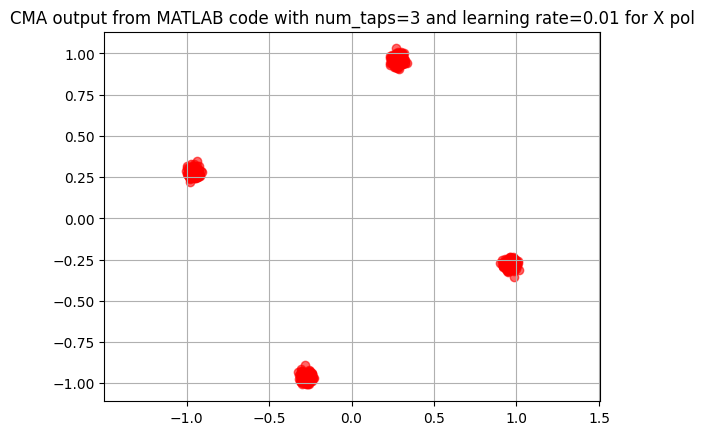

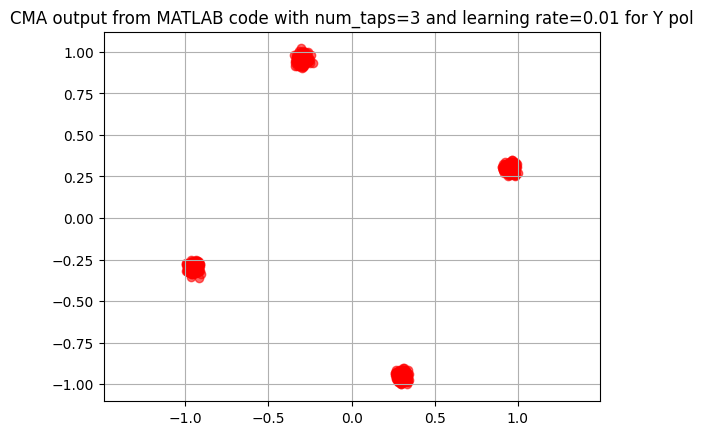

In [9]:
#Using matlab code already written for CMA we will compare this with python also
import matlab.engine
eng = matlab.engine.start_matlab()


#Change this path to where you have saved matlab
eng.addpath(r"C:\\Users\\medha\\OneDrive\\Desktop\\Coherent-Optical-Communication\\Coherent-Optical-Communication\\functions\\DSP", nargout=0)

learning_rate=10e-3
num_taps=3
ml_x_pol=matlab.double(E_out[:,0].tolist(),is_complex=True)
ml_x_pol=eng.transpose(ml_x_pol)
ml_y_pol=matlab.double(E_out[:,1].tolist(),is_complex=True)
ml_y_pol=eng.transpose(ml_y_pol)
result_x,result_y=eng.f_DSP_pol_demux_CMA(ml_x_pol,ml_y_pol,num_taps,learning_rate,nargout=2)

#Squeeze output as it is in wierd shape
result_x=np.squeeze(np.array(result_x))
result_y=np.squeeze(np.array(result_y))
#print(result_x)
plt.title(f"CMA output from MATLAB code with num_taps={num_taps} and learning rate={learning_rate} for X pol")
plt.scatter(result_x.real, result_x.imag, color='red', label='Output X-pol', alpha=0.6)
plt.xlim(-1, 1)
plt.ylim(-1,1)
plt.grid(True)
plt.axis("equal")
plt.show()


plt.title(f"CMA output from MATLAB code with num_taps={num_taps} and learning rate={learning_rate} for Y pol")
plt.scatter(result_y.real, result_y.imag, color='red', label='Output X-pol', alpha=0.6)
plt.xlim(-1, 1)
plt.ylim(-1,1)
plt.grid(True)
plt.axis("equal")
plt.show()

In [44]:
pip show matlabengine


Name: matlabengine
Version: 25.2
Summary: A module to call MATLAB from Python
Home-page: https://www.mathworks.com/
Author: MathWorks
Author-email: 
License: 
Location: c:\Users\medha\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np

def cma_pol_demux_identical(E_in, N_taps, mu_CMA):
    """
    Python replica of MATLAB f_DSP_pol_demux_CMA
    """

    # Copy and normalize (MATLAB RMS normalization)
    xpol = E_in[:, 0].astype(complex)
    ypol = E_in[:, 1].astype(complex)

    xpol = xpol / np.sqrt(np.mean(np.abs(xpol)**2))
    ypol = ypol / np.sqrt(np.mean(np.abs(ypol)**2))

    N = len(xpol)
    R = 1  # MATLAB fixed modulus

    # ---- Tap initialization (MATLAB: center tap = ceil(N/2)) ----
    pxx = np.zeros(N_taps, dtype=complex)
    pxy = np.zeros(N_taps, dtype=complex)
    pyx = np.zeros(N_taps, dtype=complex)
    pyy = np.zeros(N_taps, dtype=complex)

    center = (N_taps - 1) // 2
    pxx[center] = 1
    pyy[center] = 1

    # ---- Adaptation loop ----
    for ii in range(N_taps - 1, N):

        # MATLAB slice: xpol(ii:-1:ii-N_taps+1)
        x_vec = xpol[ii - (N_taps - 1): ii + 1][::-1]
        y_vec = ypol[ii - (N_taps - 1): ii + 1][::-1]

        # ---- Compute estimated symbols ----
        x_cap = np.dot(pxx, x_vec) + np.dot(pxy, y_vec)
        y_cap = np.dot(pyx, x_vec) + np.dot(pyy, y_vec)

        # ---- CMA errors ----
        e_x = R**2 - np.abs(x_cap)**2
        e_y = R**2 - np.abs(y_cap)**2

        # ---- Tap updates (identical to MATLAB) ----
        pxx += 2 * mu_CMA * e_x * x_cap * np.conj(x_vec)
        pxy += 2 * mu_CMA * e_x * x_cap * np.conj(y_vec)
        pyx += 2 * mu_CMA * e_y * y_cap * np.conj(x_vec)
        pyy += 2 * mu_CMA * e_y * y_cap * np.conj(y_vec)

    # ---- MATLAB conv(..., 'same') ----
    def conv_same(sig, taps):
        full = np.convolve(sig, taps, mode='full')
        start = (len(taps) - 1) // 2
        return full[start : start + len(sig)]

    x_out = conv_same(xpol, pxx) + conv_same(ypol, pxy)
    y_out = conv_same(xpol, pyx) + conv_same(ypol, pyy)

    return np.column_stack((x_out, y_out)), {
        'pxx': pxx, 'pxy': pxy, 'pyx': pyx, 'pyy': pyy
    }


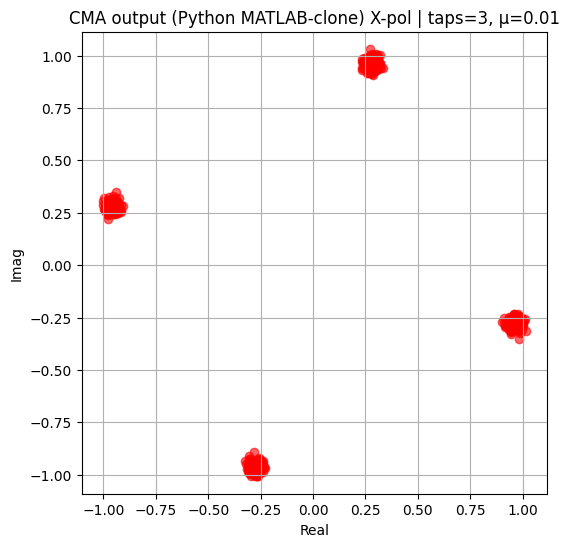

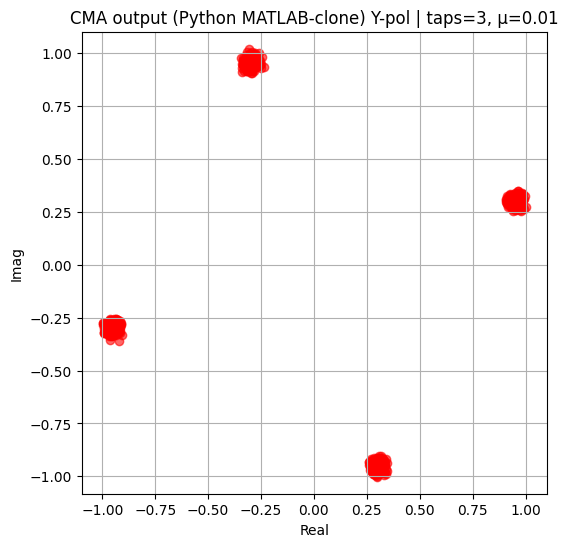


Final CMA taps:
pxx = [ 1.61984651e-03-0.01232289j  8.22750195e-01+0.0170765j
 -8.10220480e-04+0.00747032j]
pxy = [ 0.01171571-0.00522387j  0.2686925 -0.4955248j  -0.0249719 -0.00937756j]
pyx = [ 0.0197913 -0.00464898j -0.24893448-0.49591093j -0.01549527-0.00318908j]
pyy = [ 0.00162361-0.01453843j  0.83304559+0.01509069j -0.00123941+0.00151548j]


In [12]:
# === RUN MATLAB-IDENTICAL CMA ===

result_py_func, taps = cma_pol_demux_identical(
    E_out,           # your dual-pol input array (N × 2 complex)
    num_taps,        # e.g., 3 or 11
    learning_rate    # mu_CMA value
)

# Extract X and Y outputs
result_py_func_x = result_py_func[:, 0]
result_py_func_y = result_py_func[:, 1]

# === PLOTS ===

plt.figure(figsize=(6,6))
plt.title(f"CMA output (Python MATLAB-clone) X-pol | taps={num_taps}, μ={learning_rate}")
plt.scatter(result_py_func_x.real, result_py_func_x.imag,
            alpha=0.6, label="X-pol", color='red')
plt.xlabel("Real")
plt.ylabel("Imag")
plt.grid(True)
plt.axis("equal")
plt.show()

plt.figure(figsize=(6,6))
plt.title(f"CMA output (Python MATLAB-clone) Y-pol | taps={num_taps}, μ={learning_rate}")
plt.scatter(result_py_func_y.real, result_py_func_y.imag,
            alpha=0.6, label="Y-pol", color='red')
plt.xlabel("Real")
plt.ylabel("Imag")
plt.grid(True)
plt.axis("equal")
plt.show()

# === SHOW FINAL TAPS ===
print("\nFinal CMA taps:")
for name, tap in taps.items():
    print(f"{name} = {tap}")


DQN network to solve the same problem

In [13]:
#Setting
E_in_matrix=E_out

#Hyperparameters for DQN
tau=0.01
num_hidden_dim=64
replay_buffer_cap=10000
sampling_batch_size=64

In [ ]:
def apply_filters(E_in,cur_ind,num_taps, pxx, pxy, pyx, pyy):
    """This function basically just does convolution with filters and gives output at current index"""
    
    x_in = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    y_in = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))

    x=x_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    y=y_in[cur_ind-num_taps+1:cur_ind+1][::-1]

    #print(x,y,cur_ind,cur_ind-num_taps)
    
    x_out=np.dot(pxx,x)+np.dot(pxy,y)
    y_out=np.dot(pyx,x)+np.dot(pyy,y)
    return x_out,y_out

def cma_error_dualpol(x_out,y_out,Radius=1):
    """This function gives CMA error for dual polarisation and sums them"""
    e_x=((np.abs(x_out)**2-Radius**2))**2
    e_y=((np.abs(y_out)**2-Radius**2))**2
    return e_x+e_y

def get_cma_action_for_all(E_in_matrix,x_out,y_out,cur_ind,delta,Radius=1,mu_cma=0.01):
    """The main aim of this function is to do Teacher training it finds the CMA update values and returns a list of size 24(total num of taps with real and imag sep) with -1,0,1
     If the update magnitude is less than delta then we return 0 for that tap else +1 or -1 according to the sign"""
    
    """TODO: This function is coded very bad pls change when possible"""
    x_in = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    y_in = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))


    x=x_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    y=y_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    e_x=Radius**2-np.abs(x_out)**2
    e_y=Radius**2-np.abs(y_out)**2
    

    cma_update_arr_pxx=2*mu_cma*e_x*x_out*np.conj(x)
    cma_update_arr_pxy=2*mu_cma*e_x*x_out*np.conj(y)
    cma_update_arr_pyx=2*mu_cma*e_y*y_out*np.conj(x)
    cma_update_arr_pyy=2*mu_cma*e_y*y_out*np.conj(y)
    
    #print("cmaaa",cma_update_arr_pxx)
    update_array=[]

    #print("first in non cma is",cma_update_arr_pxx[0])
    for ele in cma_update_arr_pxx:
        #print("element is",ele)
        if np.abs(np.real(ele)) > delta:
            #print("update i think",np.real(ele))
            update_array.append(np.sign(np.real(ele)))

        else:
            update_array.append(0)
        
        if np.abs(np.imag(ele))>delta:
            update_array.append(np.sign(np.imag(ele)))
        
        else:
            update_array.append(0)
    
    for ele in cma_update_arr_pxy:
        if np.abs(np.real(ele)) > delta:
            update_array.append(np.sign(np.real(ele)))

        else:
            update_array.append(0)
        
        if np.abs(np.imag(ele))>delta:
            update_array.append(np.sign(np.imag(ele)))
        
        else:
            update_array.append(0)
        
    for ele in cma_update_arr_pyx:
        if np.abs(np.real(ele)) > delta:
            update_array.append(np.sign(np.real(ele)))

        else:
            update_array.append(0)
        
        if np.abs(np.imag(ele))>delta:
            update_array.append(np.sign(np.imag(ele)))
        
        else:
            update_array.append(0)

    for ele in cma_update_arr_pyy:
        if np.abs(np.real(ele)) > delta:
            update_array.append(np.sign(np.real(ele)))

        else:
            update_array.append(0)
        
        if np.abs(np.imag(ele))>delta:
            update_array.append(np.sign(np.imag(ele)))
        
        else:
            update_array.append(0)
        
    return update_array

def compute_reward(x_out,y_out):
    """For reward we need it to be neg of cma as cma error is minimum for good filters and we want high reward"""
    return -cma_error_dualpol(x_out,y_out)

def get_cma_arr(E_in_matrix,x_out,y_out,cur_ind,pxx,pxy,pyx,pyy,Radius=1,mu_cma=0.01):
    """The main aim of this function is to do Teacher training it finds the CMA update values and returns a list of size 24(total num of taps with real and imag sep) with -1,0,1
     If the update magnitude is less than delta then we return 0 for that tap else +1 or -1 according to the sign"""
    
    """TODO: This function is coded very bad pls change when possible"""
    x_in = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    y_in = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))


    x=x_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    y=y_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    e_x=Radius**2-np.abs(x_out)**2
    e_y=Radius**2-np.abs(y_out)**2
    

    cma_update_arr_pxx=2*mu_cma*e_x*x_out*np.conj(x)
    cma_update_arr_pxy=2*mu_cma*e_x*x_out*np.conj(y)
    cma_update_arr_pyx=2*mu_cma*e_y*y_out*np.conj(x)
    cma_update_arr_pyy=2*mu_cma*e_y*y_out*np.conj(y)

    #print("first is",cma_update_arr_pxx[0])
    return pxx+cma_update_arr_pxx,pxy+cma_update_arr_pxy,pyx+cma_update_arr_pyx,pyy+cma_update_arr_pyy


In [161]:
#Ignore this cell it is just to find out what the reward should be for ideal filters

x_out,y_out=apply_filters(E_in_matrix,500,num_taps,taps['pxx'],taps['pxy'],taps['pyx'],taps['pyy']) 
print(x_out,y_out)
print("Ideal reward is",compute_reward(x_out,y_out))

(-0.2169203807326971+0.9286269860934955j) (0.948268750275796+0.1379668873585006j)
Ideal reward is -0.014891211655780327


In [162]:
class QNetwork(nn.Module):
    def __init__(self,state_dim,num_actions,hidden_dim=32):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.temp1=nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_actions)  # 4 channel * 3 coeffs per channel * real and imag parts for each coeff * inc/dec each
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x=F.leaky_relu(self.temp1(x))
        return self.fc3(x)

In [163]:
class ReplayBuffer:
    def __init__(self, capacity=1000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states)
        )

    def __len__(self):
        return len(self.buffer)

In [164]:
class DQNAgent:
    def __init__(self, num_taps_per_filter, delta=0.01, gamma=0.99, lr=1e-3):
        
        self.num_taps_per_filter = num_taps_per_filter
        self.num_filters=4
        #We set our state dimension as twice the total number_coefficients as we have real and imaginary parts
        self.num_coeffs=num_taps_per_filter*self.num_filters
        self.state_dim = 2*self.num_coeffs
        #The actions are increase,decrease and remain same
        self.num_actions=3
        
        self.gamma = gamma


        self.q_net = QNetwork(self.state_dim,self.num_actions,hidden_dim=32)
        self.target_net = QNetwork(self.state_dim,self.num_actions,hidden_dim=32)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer()
        self.loss_fn = nn.MSELoss()


    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        with torch.no_grad():
            q_vals = self.q_net(torch.FloatTensor(state))
            return torch.argmax(q_vals).item()

    def update(self, batch_size=128):
        if len(self.replay_buffer) < batch_size:
            return None
        states, actions, rewards, next_states = self.replay_buffer.sample(batch_size)
        q_vals = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_vals = self.target_net(next_states).max(1)[0]
            #print("next q val is",next_q_vals)
            #Uncomment below to use DDQN
            next_actions = self.q_net(next_states).argmax(1,keepdims=True)        # Online SELECTS
            # print("next actions shape is",next_actions.shape)
            # next_q_vals = self.target_net(next_states).gather(1, next_actions)  # Target EVALUATES
            # next_q_vals=next_q_vals.squeeze()
            targets = rewards + self.gamma * next_q_vals
        # print("targets are:",targets.shape)
        # print("q values are",q_vals.shape)
        loss = self.loss_fn(q_vals, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def soft_update(self, tau=0.01):
        for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [165]:
"""Making a function that takes in the index of the agent and gives out which filter,which tap,which part(real or imag) so returns a
tuple of the form (1,1,0) where 0 represents real and 1 represents imag"""

def create_agent_index_to_filter_index_dict(num_filters=4,num_taps_per_filter=3):
    conversion_dict={}

    index=0
    for filter_tap in range(num_filters):
        for tap_index in range(num_taps_per_filter):
            for ri in range(2):
                conversion_dict[index]=(filter_tap,tap_index,ri)
                index+=1
    return conversion_dict

Doing Teacher training with CMA

In [166]:
num_taps = 3
num_coeffs = num_taps * 4   # 4 channels * 3 taps = 12 complex coeffs
num_episodes = 400
steps_per_episode = len(E_in_matrix[:,0])
delta = 1e-3
delta_decay=0.9995
tau=0.01
total_num_filter_nums=24
agent_ind_filt_ind_map=create_agent_index_to_filter_index_dict()

agent_list=[DQNAgent(num_taps_per_filter=num_taps,delta=delta,lr=1e-4) for i in range(total_num_filter_nums)]
#print(agent.action_map)
epsilon, epsilon_min, epsilon_decay = 1.0, 0.05, 0.995

#This update array is basically used to update the coefficients of all taps at every timestep
update_array=np.zeros(total_num_filter_nums)

for episode in range(400):
    # initialize filter weights
    
    pxx = np.zeros(num_taps, dtype=complex); pxx[num_taps//2+1] = 1
    pxy = np.zeros(num_taps, dtype=complex)
    pyx = np.zeros(num_taps, dtype=complex)
    pyy = np.zeros(num_taps, dtype=complex); pyy[num_taps//2+1] = 1

    #To see how cma filters are moving this is just to compare cma with what we have got

    # state = real and imag parts of all coefficients
    state = np.concatenate([
        np.real(np.concatenate([pxx, pxy, pyx, pyy])),
        np.imag(np.concatenate([pxx, pxy, pyx, pyy]))
    ])
    #Normalising the state

    filters_state = [pxx, pxy, pyx, pyy]
    x_out,y_out=apply_filters(E_in_matrix,num_taps-1,num_taps,*filters_state)

    delta=1e-3
    for cur_sample in range(num_taps,steps_per_episode):

        #Decay delta
        #delta=delta*delta_decay

        #Use cma directed action to get where to go as it always gives some value we will never do the do nothing action
        if random.random() < epsilon:
            update_array=np.array([random.randint(0,2)-1 for i in range(total_num_filter_nums)])
        else:
            update_array=np.array(get_cma_action_for_all(E_in_matrix,x_out,y_out,cur_sample,delta=delta,Radius=1))  
        
        pxx_cma,pxy_cma,pyx_cma,pyy_cma=get_cma_arr(E_in_matrix,x_out,y_out,cur_sample,*filters_state,Radius=1)
        
        #print("update arr is",update_array[:6])
        #print("cma is",pxx_cma)
        
        for agent_index in range(total_num_filter_nums):
            filter_num,tap_num,real_imag=agent_ind_filt_ind_map[agent_index]

        #print("direction is",direction)
            if real_imag==0:
                "Change the real part"
                filters_state[filter_num][tap_num]+= update_array[agent_index]*delta
            elif real_imag==1:
                filters_state[filter_num][tap_num]+=1j*update_array[agent_index]*delta
        
        # update chosen coefficient
        x_out,y_out = apply_filters(E_in_matrix,cur_sample,num_taps,*filters_state)
        reward = compute_reward(x_out,y_out)
        
        next_state = np.concatenate([
            np.real(np.concatenate(filters_state)),
            np.imag(np.concatenate(filters_state))
        ])
        
        #print("ours is",filters_state[0])

        for agent_index in range(total_num_filter_nums):
            #Here I am doing update_array[agent_index]+1 as update array is a list which has values -1,0,1 but we need actions from 0 to 2 so I add one basically 0th index is neg direction
            agent_list[agent_index].replay_buffer.push( state , update_array[agent_index]+1 , reward , next_state)
        
        state = next_state
    total_loss=0
    for agent_index in range(total_num_filter_nums):
        loss = agent_list[agent_index].update()
        agent_list[agent_index].soft_update(tau=tau)
        total_loss+=loss

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 5 == 0:
        print(f"Episode {episode+1}, epsilon={epsilon:.3f}, last_loss={total_loss:.6f}, reward={reward:.6f}")
       
print("\nTraining complete")
print("Final filters:")
print("pxx = ", pxx)
print("pxy = ", pxy)
print("pyx = ", pyx)
print("pyy = ", pyy)

Episode 5, epsilon=0.975, last_loss=36.610756, reward=-1.095714
Episode 10, epsilon=0.951, last_loss=39.799204, reward=-1.459845
Episode 15, epsilon=0.928, last_loss=33.207668, reward=-0.678561


KeyboardInterrupt: 

Now letting the DQN learn by its own without help from cma

In [167]:
epsilon=1
for episode in range(num_episodes):

    pxx = np.zeros(num_taps, dtype=complex); pxx[num_taps//2+1] = 1
    pxy = np.zeros(num_taps, dtype=complex)
    pyx = np.zeros(num_taps, dtype=complex)
    pyy = np.zeros(num_taps, dtype=complex); pyy[num_taps//2+1] = 1


    # state = real and imag parts of all coefficients
    state = np.concatenate([
        np.real(np.concatenate([pxx, pxy, pyx, pyy])),
        np.imag(np.concatenate([pxx, pxy, pyx, pyy]))
    ])
    # Normalize state to zero mean, unit variance
    # initial_mean=state.mean()
    # initial_dev=state.std()
    # state = (state - initial_mean) / (initial_dev + 1e-8)
    
    filters_state = [pxx, pxy, pyx, pyy]
    x_out,y_out=apply_filters(E_in_matrix,num_taps-1,num_taps,*filters_state)
   

    delta =1e-3
    for cur_sample in range(num_taps,steps_per_episode):


        cur_action_arr=[]
        for agent_index in range(total_num_filter_nums):
            
            cur_action=agent_list[agent_index].select_action(state,epsilon)
            cur_action_arr.append(cur_action)
            direction=cur_action-1
            filter_num,tap_num,real_imag=agent_ind_filt_ind_map[agent_index]

            if real_imag==0:
                "Change the real part"
                filters_state[filter_num][tap_num]+= direction*delta
            elif real_imag==1:
                filters_state[filter_num][tap_num]+=1j*direction*delta
        
        # update chosen coefficient
        x_out,y_out = apply_filters(E_in_matrix,cur_sample,num_taps,*filters_state)
        reward = compute_reward(x_out,y_out)

        next_state = np.concatenate([
            np.real(np.concatenate(filters_state)),
            np.imag(np.concatenate(filters_state))
        ])

        #agent.replay_buffer.push(state, action, reward, next_state)
        for agent_index in range(total_num_filter_nums):
            #Here I am doing update_array[agent_index]+1 as update array is a list which has values -1,0,1 but we need actions from 0 to 2 so I add one basically 0th index is neg direction
            agent_list[agent_index].replay_buffer.push( state , cur_action_arr[agent_index] , reward , next_state)
        
        state = next_state
        
        #state = (state - initial_mean) / (initial_dev + 1e-8)
        # state= (state-state.mean())/(state.std()+1e-8)
    
    total_loss=0
    for agent_index in range(total_num_filter_nums):
        loss = agent_list[agent_index].update()
        #print(agent_list[agent_index].q_net.parameters)
        #print(loss)
        agent_list[agent_index].soft_update(tau=tau)
        total_loss+=loss


    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 5 == 0:
        print(f"Episode {episode+1}, epsilon={epsilon:.3f}, last_loss={loss:.6f}, reward={reward:.6f}")

print("\nTraining complete")
print("Final filters:")
print("pxx = ", pxx)
print("pxy = ", pxy)
print("pyx = ", pyx)
print("pyy = ", pyy)

Episode 5, epsilon=0.975, last_loss=1.249165, reward=-0.711534
Episode 10, epsilon=0.951, last_loss=1.126559, reward=-0.588923
Episode 15, epsilon=0.928, last_loss=1.120845, reward=-0.337025
Episode 20, epsilon=0.905, last_loss=1.303468, reward=-0.571666
Episode 25, epsilon=0.882, last_loss=1.401269, reward=-0.490681
Episode 30, epsilon=0.860, last_loss=1.215285, reward=-0.574769
Episode 35, epsilon=0.839, last_loss=1.473795, reward=-0.449199
Episode 40, epsilon=0.818, last_loss=1.493759, reward=-0.658621
Episode 45, epsilon=0.798, last_loss=1.292663, reward=-0.926415
Episode 50, epsilon=0.778, last_loss=1.624359, reward=-0.793814
Episode 55, epsilon=0.759, last_loss=1.689997, reward=-0.821607
Episode 60, epsilon=0.740, last_loss=2.155347, reward=-0.848749
Episode 65, epsilon=0.722, last_loss=3.370738, reward=-0.644456
Episode 70, epsilon=0.704, last_loss=3.332654, reward=-0.789291
Episode 75, epsilon=0.687, last_loss=5.057937, reward=-0.821248
Episode 80, epsilon=0.670, last_loss=5.68

KeyboardInterrupt: 

Testing the model by trying it on the same data and plotting the constellation 

In [ ]:
epsilon_test=0
# initialize filter weights

# Initialised coefficients:

#Setting this just to check if it needs more iterations to converge to the optimal filter 
num_repetitions_test=1

pxx = np.zeros(num_taps, dtype=complex); pxx[num_taps//2+1] = 1
pxy = np.zeros(num_taps, dtype=complex)
pyx = np.zeros(num_taps, dtype=complex)
pyy = np.zeros(num_taps, dtype=complex); pyy[num_taps//2+1] = 1

print("original filters from cma:")
print("pxx = ", taps['pxx'])
print("pxy = ", taps['pxy'])
print("pyx = ", taps['pyx'])    
print("pyy = ", taps['pyy'])
# state = real and imag parts of all coefficients
state = np.concatenate([
    np.real(np.concatenate([pxx, pxy, pyx, pyy])),
    np.imag(np.concatenate([pxx, pxy, pyx, pyy]))
])

#Normalise state so that the neural network can learn
state = (state - state.mean()) / (state.std() + 1e-8)

initial_mean=state.mean()
initial_dev=state.std()
filters_state = [pxx, pxy, pyx, pyy]
x_out,y_out=apply_filters(E_in_matrix,num_taps-1,num_taps,*filters_state)

delta=1e-3
for k in range(num_repetitions_test):
    for cur_sample in range(num_taps,steps_per_episode):
        delta=delta*delta_decay
        for agent_index in range(total_num_filter_nums):
            cur_action=agent_list[agent_index].select_action(state,epsilon)
            direction=cur_action-1
            filter_num,tap_num,real_imag=agent_ind_filt_ind_map[agent_index]

            if real_imag==0:
                "Change the real part"
                filters_state[filter_num][tap_num]+= direction*delta
            elif real_imag==1:
                filters_state[filter_num][tap_num]+=1j*direction*delta
        
        #Use cma directed action to get where to go as it always gives some value we will never do the do nothing action
        
        

        # update chosen coefficient
        x_out,y_out = apply_filters(E_in_matrix,cur_sample,num_taps,*filters_state)
        reward = compute_reward(x_out,y_out)

        next_state = np.concatenate([
            np.real(np.concatenate(filters_state)),
            np.imag(np.concatenate(filters_state))
        ])

        state=next_state
        state = (state - state.mean()) / (state.std() + 1e-8)



print("\nTraining complete")
print("Final filters:")
print("pxx = ", filters_state[0])
print("pxy = ", filters_state[1])
print("pyx = ", filters_state[2])
print("pyy = ", filters_state[3])

original filters from cma:
pxx =  [ 0.00492366+0.00669177j -0.0066746 +0.00045783j  0.76446001-0.01381642j]
pxy =  [ 0.03500088-0.03572486j -0.04585337+0.06392307j  0.52174257-0.36490814j]
pyx =  [ 0.02040849+0.02485906j -0.03057084-0.07117022j -0.47161543-0.4077163j ]
pyy =  [-0.02171217-0.00171351j  0.01593907-0.03362927j  0.75028152+0.04584384j]

Training complete
Final filters:
pxx =  [-0.70335514-0.68775405j  0.68809253+0.10947832j  0.99779356+0.00725162j]
pxy =  [ 0.68985041-0.68998368j  0.00140139-0.67911303j -0.09238454-0.6737564j ]
pyx =  [-9.38071034e-03-0.6762782j -6.04447743e-05+0.1457455j
 -6.65784601e-01-0.4482396j]
pyy =  [ 0.00901162-0.1141204j  -0.67753822-0.62485052j  0.99443002+0.04544532j]


[array([-0.70335514-0.68775405j,  0.68809253+0.10947832j,
        0.99779356+0.00725162j]), array([ 0.68985041-0.68998368j,  0.00140139-0.67911303j,
       -0.09238454-0.6737564j ]), array([-9.38071034e-03-0.6762782j, -6.04447743e-05+0.1457455j,
       -6.65784601e-01-0.4482396j]), array([ 0.00901162-0.1141204j , -0.67753822-0.62485052j,
        0.99443002+0.04544532j])]
{'pxx': array([ 0.00492366+0.00669177j, -0.0066746 +0.00045783j,
        0.76446001-0.01381642j]), 'pxy': array([ 0.03500088-0.03572486j, -0.04585337+0.06392307j,
        0.52174257-0.36490814j]), 'pyx': array([ 0.02040849+0.02485906j, -0.03057084-0.07117022j,
       -0.47161543-0.4077163j ]), 'pyy': array([-0.02171217-0.00171351j,  0.01593907-0.03362927j,
        0.75028152+0.04584384j])}


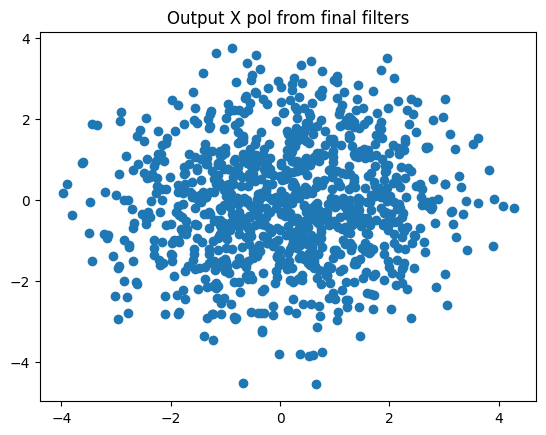

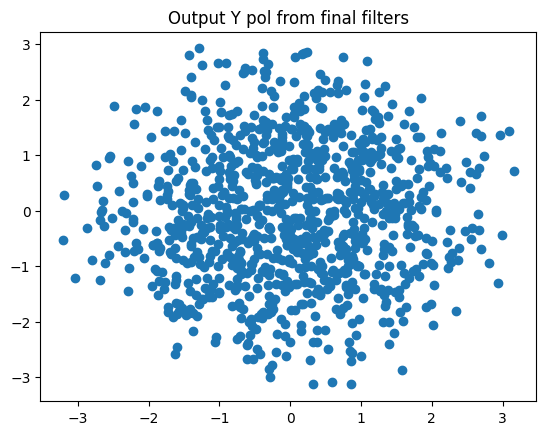

In [ ]:
#Plotting Final from the filters
pxx,pxy,pyx,pyy=filters_state

print(filters_state)
#pxx,pxy,pyx,pyy=taps['pxx'],taps['pxy'],taps['pyx'],taps['pyy']
print(taps)
x_test = E_out[:, 0] / np.sqrt(np.mean(np.abs(E_out[:, 0])**2))
y_test = E_out[:, 1] / np.sqrt(np.mean(np.abs(E_out[:, 1])**2))

x_out = np.convolve(x_test, pxx, mode='full') + np.convolve(y_test, pxy, mode='full')
y_out = np.convolve(x_test, pyx, mode='full') + np.convolve(y_test, pyy, mode='full')


plt.title("Output X pol from final filters")
plt.scatter(x_out.real, x_out.imag, label='Output X-pol')
plt.show()

plt.title("Output Y pol from final filters")
plt.scatter(y_out.real, y_out.imag, label='Output Y-pol')
plt.show()